## System Kinematics


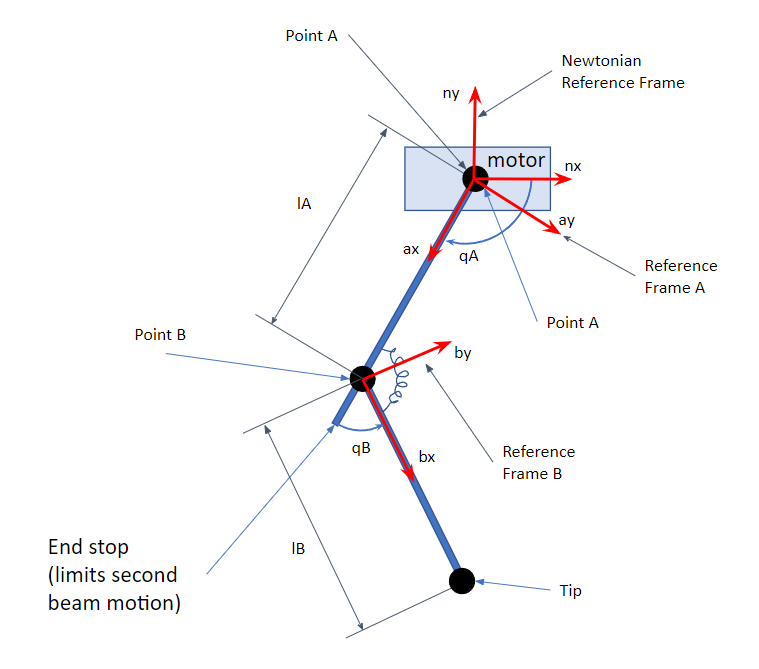

The figure above shows the model of the system we are using and the naming conventions we follow in this code. The z axes of all refence frames come out of the page in this figure.

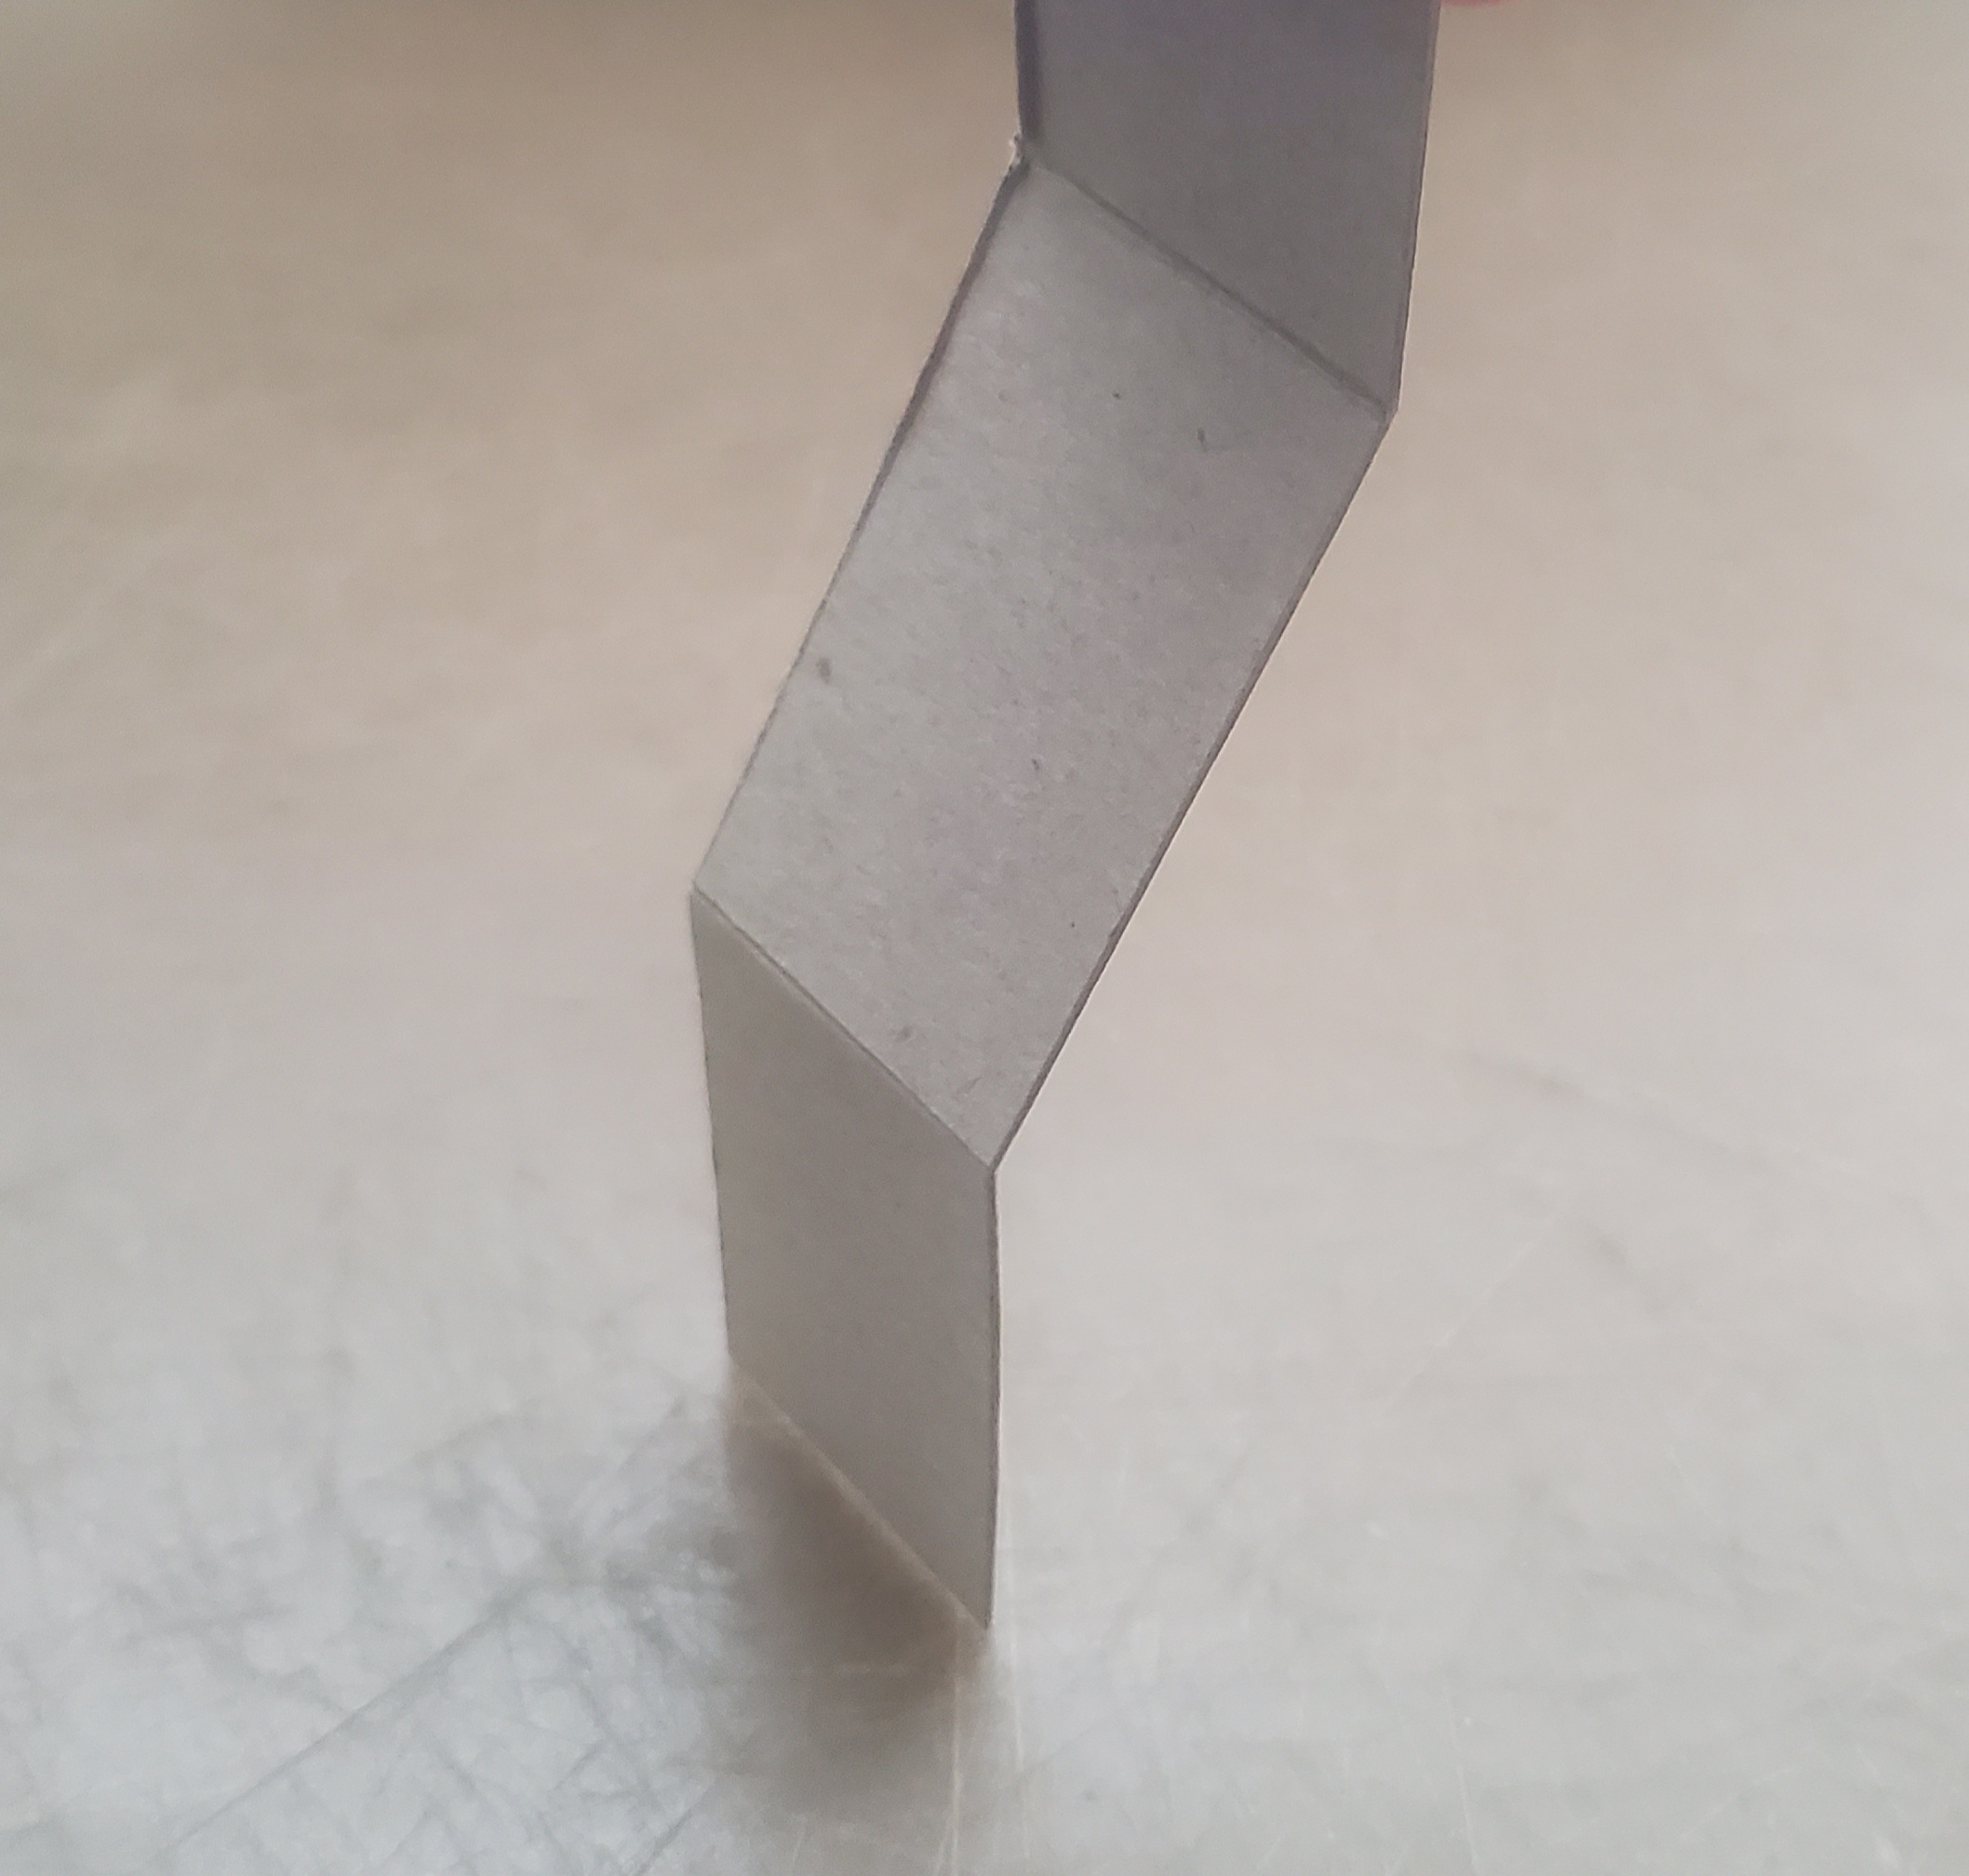

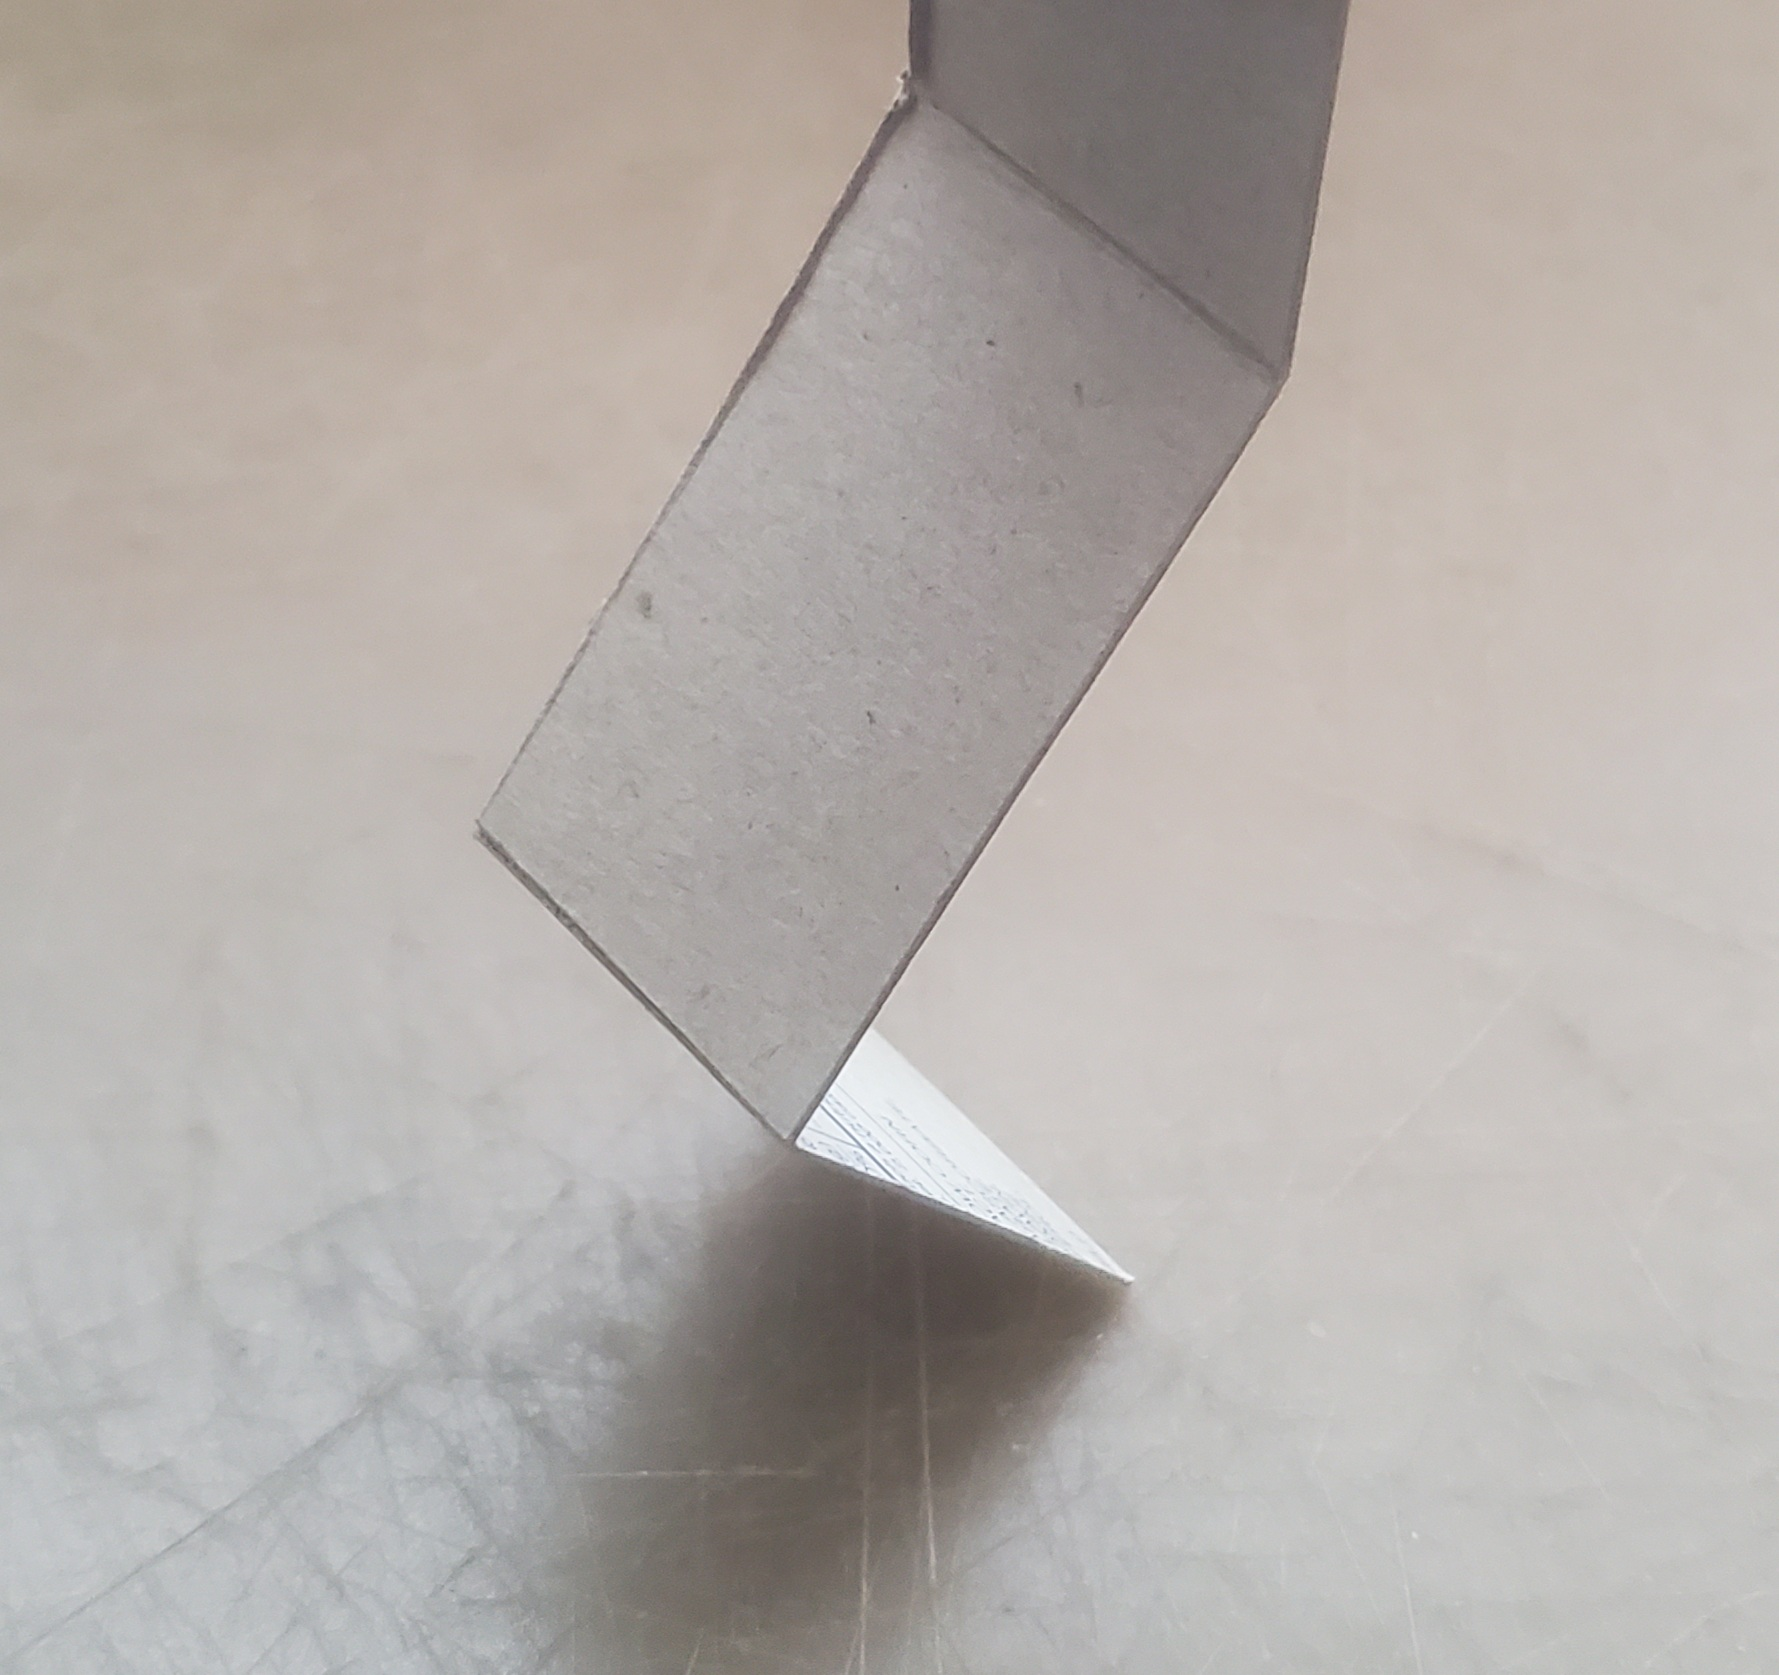

The images above show a physical prototype of this system with the motor replaced by a joint at the top.

In [ ]:
#import packages
!pip install pynamics
%matplotlib inline

import pynamics
from pynamics.frame import Frame
from pynamics.system import System
import numpy as np
import sympy
import math
import matplotlib.pyplot as plt
plt.ion()
from math import pi

system = System()
pynamics.set_system(__name__,system)

#define variables and constants
from pynamics.variable_types import Differentiable,Constant

lA = Constant(5,'lA',system)#leg lenght in cm
lB = Constant(5,'lB',system)#leg lenght in cm
print(system.constant_values)

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)

state1 = {}
state1[qA]=15*pi/180
state1[qB]=15*pi/180

#declare frames
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)

#define frame rotaions
system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,-1],qA,system)

B.rotate_fixed_axis(A,[0,0,1],qB,system)

{lA: 5, lB: 5}


In [ ]:
state2={}
state2[qA]=110*pi/180
state2[qB]=5*pi/180

In [ ]:
#compose kinematics
p_NA = 0*N.x + 0*N.y + 0*N.z

In [ ]:
p_AB=p_NA+lA*A.x

In [ ]:
p_Btip=p_AB+lB*B.x

In [ ]:
points=[p_NA,p_AB,p_Btip] 

px=[item.dot(N.x) for item in points]              
px=[item.subs(system.constant_values) for item in px]
px

[0, 5*cos(qA), 5*sin(qA)*sin(qB) + 5*cos(qA)*cos(qB) + 5*cos(qA)]

In [ ]:
px1=[item.subs({**system.constant_values,**state1}) for item in px]  
px1

[0, 4.82962913144534, 9.82962913144534]

In [ ]:
px2=[y.subs({**system.constant_values,**state2}) for y in px]  
px2

[0, -1.71010071662834, -3.00419594214095]

In [ ]:
points=[p_NA,p_AB,p_Btip]
py=[item.dot(N.y) for item in points]
py=[item.subs(system.constant_values) for item in py]
py

[0, -5*sin(qA), -5*sin(qA)*cos(qB) - 5*sin(qA) + 5*sin(qB)*cos(qA)]

In [ ]:
py1=[item.subs({**system.constant_values,**state1}) for item in py]  
py1

[0, -1.2940952255126, -1.2940952255126]

In [ ]:
py2=[y.subs({**system.constant_values,**state2}) for y in py]  
py2

[0, -4.69846310392954, -9.52809223537488]

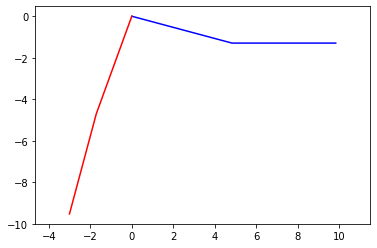

In [ ]:
plt.plot(px1,py1,'b',px2,py2,'r')                 
plt.axis('equal')  
plt.show()

The red lines in the graph above show the leg in a midstride position.

In [ ]:
v_Btip = p_Btip.time_derivative() # Taking time derivative of end effector vector 
v_Btip

-lA*qA_d*A.y + lB*B.y*(-qA_d + qB_d)

In [ ]:
vx_Btip = v_Btip.dot(N.x)
vx_Btip

-lA*qA_d*sin(qA) + lB*(-qA_d + qB_d)*sin(qA)*cos(qB) - lB*(-qA_d + qB_d)*sin(qB)*cos(qA)

In [ ]:
vy_Btip = v_Btip.dot(N.y)
vy_Btip

-lA*qA_d*cos(qA) + lB*(-qA_d + qB_d)*sin(qA)*sin(qB) + lB*(-qA_d + qB_d)*cos(qA)*cos(qB)

In [ ]:
v=sympy.Matrix([vx_Btip,vy_Btip])
v

Matrix([
[-lA*qA_d*sin(qA) + lB*(-qA_d + qB_d)*sin(qA)*cos(qB) - lB*(-qA_d + qB_d)*sin(qB)*cos(qA)],
[-lA*qA_d*cos(qA) + lB*(-qA_d + qB_d)*sin(qA)*sin(qB) + lB*(-qA_d + qB_d)*cos(qA)*cos(qB)]])

In [ ]:
q_d=sympy.Matrix([qA_d,qB_d])
q_d

Matrix([
[qA_d],
[qB_d]])

In [ ]:
J = v.jacobian(q_d) # Computing the jacobian 
J

Matrix([
[-lA*sin(qA) - lB*sin(qA)*cos(qB) + lB*sin(qB)*cos(qA), lB*sin(qA)*cos(qB) - lB*sin(qB)*cos(qA)],
[-lA*cos(qA) - lB*sin(qA)*sin(qB) - lB*cos(qA)*cos(qB), lB*sin(qA)*sin(qB) + lB*cos(qA)*cos(qB)]])

In [ ]:
J1=J.subs(system.constant_values).subs(state1)
J1


Matrix([
[ -1.2940952255126,   0],
[-9.82962913144534, 5.0]])

In [ ]:
J2=J.subs(system.constant_values).subs(state2)
J2

Matrix([
[-9.52809223537488, 4.82962913144534],
[ 3.00419594214095, -1.2940952255126]])

In [ ]:
# Assuming end effector velocity to be 25cm/s in x [1] 
#v = J*qdot
v2=sympy.Matrix([25,0])
q2_d=J2.inv()*v2
q2_d

Matrix([
[14.8480775301221],
[34.4692827739302]])

In [ ]:
f=sympy.Matrix([2.6,-0.47])   # Computing torques at the robot's joints with forces in N
t2=J2.transpose()*f
t2

Matrix([
[-26.1850119047809],
[ 13.1652604977488]])

The force values used are the verical and propulsive ground reaction forces as found from experimental measurement in refence [2].<br>
The resulting torques are in N*cm.


1. A single leg of the robot has 2 degrees of freedom since it is a 2D planar mechanism. With 4 legs: 8 DOF and 4 motors.<br>
Nonlinear springs determine the states of the remaining DOFs in the undriven joints.

2. In order to create a useful gait with our two degree of freedom system the nonlinear spring on the second joint limits the angle of the second beam of the leg from moving past qb = 0 in the negative direction but allows for easy movement in the positive direction. When combined with the motor driving the first beam forwards and backwards a useful gait will be produced as when swung forward the second beam will be easily pushed up by the ground producing little force and when swung backward the second beam of the leg will lock in place and push against the ground with high force producing a net forward work.

3. We estimated the end effector forces for a leg in the walking position by using our biomechanics background research. We used the peak vertical and purposive (horizontal) ground reaction forces measured in \[2] and applied them simultaneously to the tip of the limb.
4. We estimated the end effector speed when walking and in contact with the ground to be equal to the forward speed of the robot. We used the forward speeds found in our biomechanics background research notably \[1] and then used the inverse of the jacobian to calcuate the required joint angular velocities.






Refrences:<br>
[1]A. J. Parker and K. A. Clarke, “Gait topography in rat locomotion,” Physiology & Behavior, 14-Feb-2003. [Online]. Available: https://www.sciencedirect.com/science/article/abs/pii/0031938490902586. [Accessed: 12-Feb-2022]<br>
[2]C. S. Howard, D. C. Blakeney, J. Medige, O. J. Moy, and C. A. Peimer, “Functional assessment in the rat by ground reaction forces,” Journal of Biomechanics, vol. 33, no. 6, pp. 751–757, 2000. 
